In [1]:
import requests
import pandas as pd

key = 'API_key'

### Gathering Data

In [2]:
#function to retrieve and format data 
def get_data(params,col):
    url = f'https://api.census.gov/data/2019/acs/acs1/profile?get={params}&for=state:*&key={key}'
    #grab data
    data = requests.get(url)
    #convert to a dataframe
    df = pd.DataFrame(data=data.json(),columns=col)
    #remove default headers and unneeded columns
    df = df.drop(index=0)
    df = df.drop(columns='state#')
    #remove null values
    df = df.dropna()
    #convert column data types
    for i in df.columns.values.tolist():
        if i == 'state':
            df[i] = df[i].astype('string')
        else:
            df[i] = df[i].astype('int64')
    #sort df in alphebetical order
    df = df.sort_values(by='state')
    df = df.reset_index()
    return df

In [3]:
#grabbing race data
race_params = 'NAME,DP05_0022E,DP05_0033E,DP05_0037E,DP05_0038E,DP05_0039E,DP05_0044E,DP05_0053E,DP05_0058E'
race_col= ['state','over_21','pop_total','white','black','native','asian','pacific','multiracial','state#']

race = get_data(params=race_params,col=race_col)

In [4]:
#gathering state population data
pop = pd.read_csv('~/state_areas.csv')
pop = pop.drop(index=51)

pop = pop.merge(race[['state','pop_total']], on='state')

pop = pop.assign(pop_density = pop['pop_total']/pop['area (sq. mi)'])
pop = pop.drop(columns='area (sq. mi)')

In [5]:
#grabbing education data
edu_col= ['state','edu_total','no_hs','some_hs','hs_diploma','some_college','associate','bachelor','grad','state#']
edu_params = 'NAME,DP02_0059E,DP02_0060E,DP02_0061E,DP02_0062E,DP02_0063E,DP02_0064E,DP02_0065E,DP02_0066E'

edu = get_data(params=edu_params,col=edu_col)

In [6]:
#grabbing income data
income_col= ['state','households','<10k','10k-15k','15k-25k','25k-35k','35k-50k','50k-75k','75k-100k','100k-150k','150k-200k','>200k','median_income','mean_income','state#']
income_params = 'NAME,DP03_0051E,DP03_0052E,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,DP03_0062E,DP03_0063E'

income = get_data(params=income_params,col=income_col)

### Calculating Percentages

In [7]:
def percent(data,total,target):
    column = (data[target]/data[total])*100
    return column

In [8]:
#adding pct columns to income df
income_pct = pd.DataFrame()
income_pct['state'] = income['state']

for i in ['<10k','10k-15k','15k-25k','25k-35k','35k-50k','50k-75k','75k-100k','100k-150k','150k-200k','>200k']: 
    income_pct[f'{i}_pct'] = percent(data=income,total='households',target=i)

income = income.merge(income_pct,on='state')
income = income.drop(columns='index')

In [9]:
#adding pct columns to education df
edu_pct = pd.DataFrame()
edu_pct['state'] = edu['state']

for i in ['no_hs','some_hs','hs_diploma','some_college','associate','bachelor','grad']: 
    edu_pct[f'{i}_pct'] = percent(data=edu,total='edu_total',target=i)
    
edu = edu.merge(edu_pct,on='state')
edu = edu.drop(columns='index')

In [10]:
#adding pct columns to racial df
race_pct = pd.DataFrame()
race_pct['state'] = race['state']

for i in ['white','black','native','asian','pacific','multiracial']: 
    race_pct[f'{i}_pct'] = percent(data=race,total='pop_total',target=i)

race = race.merge(race_pct,on='state')
race = race.drop(columns='index')
race = race.assign(nonwhite_pct = 100 - race['white_pct'])

In [12]:
#exporting tables
pop.to_csv('~/projects/census-pop.csv')
income.to_csv('~/projects/census-income.csv')
edu.to_csv('~/projects/census-edu.csv')
race.to_csv('~/projects/census-race.csv')

### Reformatting Tables for Tableau

In [29]:
#creating table for a racial pie chart
race_bd = pd.DataFrame(columns=['state','race','value'])

for s in race['state']:
    for r in ['white_pct','black_pct','asian_pct','native_pct','multiracial_pct']:
        race_bd = race_bd.append({'state': s, 'race': r, 'value': race.loc[race['state']== s][r].mean()},
                                 ignore_index=True
                                )

,state,race,value
0,Alabama,white_pct,67.841107
1,Alabama,black_pct,26.912119
2,Alabama,asian_pct,1.348695
3,Alabama,native_pct,0.474488
4,Alabama,multiracial_pct,1.866583


In [32]:
#creating table for income distribution
inc_f = pd.DataFrame(columns=['state','bracket','value'])

for s in income['state']:
    for b in ['<10k_pct','10k-15k_pct','15k-25k_pct','25k-35k_pct','35k-50k_pct','50k-75k_pct','75k-100k_pct','100k-150k_pct','150k-200k_pct','>200k_pct']:
        inc_f = inc_f.append({'state': s, 'bracket': b, 'value': income.loc[income['state']== s][b].mean()},
                                 ignore_index=True
                                )

,state,bracket,value
0,Alabama,<10k_pct,8.145023
1,Alabama,10k-15k_pct,5.462390
2,Alabama,15k-25k_pct,10.919510
3,Alabama,25k-35k_pct,10.332234
4,Alabama,35k-50k_pct,13.409476


In [33]:
#creating table for education distribution
edu_f = pd.DataFrame(columns=['state','level','value'])

for s in race['state']:
    for l in ['no_hs_pct','some_hs_pct','hs_diploma_pct','some_college_pct','associate_pct','bachelor_pct','grad_pct']:
        edu_f = edu_f.append({'state': s, 'level': l, 'value': edu.loc[edu['state']== s][l].mean()},
                                 ignore_index=True
                                )

,state,level,value
0,Alabama,no_hs_pct,3.878504
1,Alabama,some_hs_pct,9.010350
2,Alabama,hs_diploma_pct,30.929258
3,Alabama,some_college_pct,20.847051
4,Alabama,associate_pct,8.985381


In [31]:
#exporting tables to csv files
edu_f.to_csv('~/projects/census-eduf.csv')
inc_f.to_csv('~/projects/census-incf.csv')
race_bd.to_csv('~/projects/census-race-bd.csv')

In [35]:
race.sort_values(by='white_pct').head(10)

,state,over_21,pop_total,white,black,native,asian,pacific,multiracial,white_pct,black_pct,native_pct,asian_pct,pacific_pct,multiracial_pct,nonwhite_pct
11,Hawaii,1069806,1415872,341211,26923,6129,547843,90070,316468,24.099000,1.901514,0.432878,38.692975,6.361451,22.351455,75.901000
8,District of Columbia,544046,705749,300058,320704,1886,28722,-999999999,23321,42.516249,45.441651,0.267234,4.069719,-141693.434776,3.304433,57.483751
20,Maryland,4476458,6045680,3296909,1830059,19164,386194,962,205558,54.533303,30.270524,0.316987,6.387933,0.015912,3.400081,45.466697
10,Georgia,7645283,10617423,6131699,3390968,42316,439416,2293,284421,57.751292,31.937769,0.398552,4.138631,0.021597,2.678814,42.248708
24,Mississippi,2131424,2976149,1726970,1130608,14634,31154,-999999999,43664,58.027001,37.988958,0.491709,1.046789,-33600.468223,1.467131,41.972999
4,California,29044071,39512223,23484958,2282144,321112,5865435,25912,1978145,59.437197,5.775792,0.812690,14.844609,0.065580,5.006413,40.562803
18,Louisiana,3371916,4648794,2874784,1504017,28561,81506,-999999999,93067,61.839350,32.352842,0.614374,1.753272,-21510.955293,2.001960,38.160650
32,New York,14674437,19453561,12293680,3084304,73560,1680219,3152,649298,63.195011,15.854701,0.378131,8.637077,0.016203,3.337682,36.804989
1,Alaska,523018,731545,469771,22551,115544,43678,-999999999,57476,64.216282,3.082654,15.794517,5.970651,-136696.990479,7.856796,35.783718
39,Puerto Rico,2480442,3193694,2054764,395439,3082,6573,-999999999,227090,64.338161,12.381869,0.096503,0.205812,-31311.703595,7.110575,35.661839


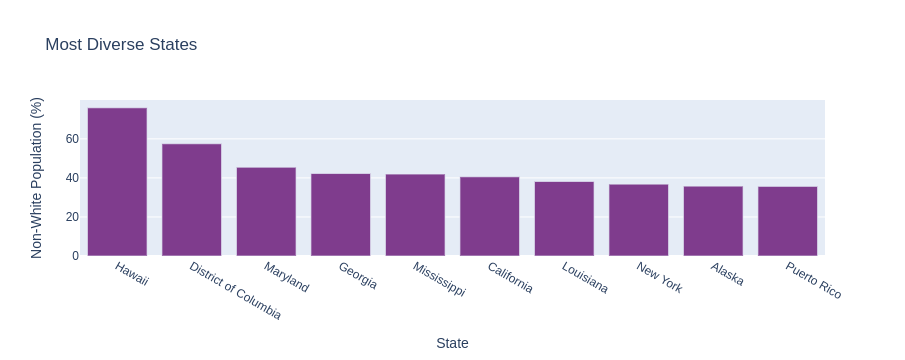

In [44]:
import plotly.express as px

px.bar(data_frame=race.sort_values(by='white_pct').head(10),
       x='state',
       y='nonwhite_pct',
       title='Most Diverse States',
       labels={'state':'State','nonwhite_pct':'Non-White Population (%)'},
       color_discrete_sequence=px.colors.qualitative.Bold
      )

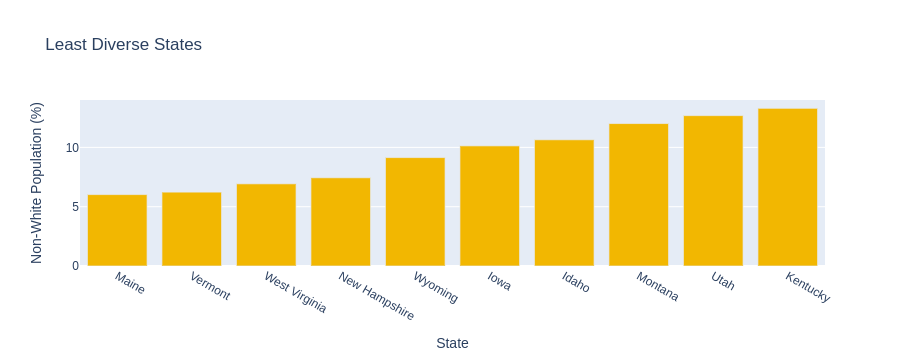

In [45]:
px.bar(data_frame=race.sort_values(by='white_pct', ascending=False).head(10),
       x='state',
       y='nonwhite_pct',
       title='Least Diverse States',
       labels={'state':'State','nonwhite_pct':'Non-White Population (%)'},
       color_discrete_sequence=[px.colors.qualitative.Bold[3]]
      )